In [1]:
%matplotlib inline
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
    Define a current generator and Integrate-and-Fire class
"""

class current_generator:
    """
        A class defining a currrent generator
    """
    def __init__(self, I=1, It=50, It_start=10, freq=0, time_step=1):
        """
            Initialize current generator:
            (Current Amplitude)I = 1 nA
            (Time length of current) It = 50 ms
            (Time start of current) It_start = 10 ms
            (Frequency of current) freq = 0 (constant current)
            (Time Step of iteration) time_step = 1 ms
        """
        
        # Set current variables
        self.I = I
        self.It = It
        self.It_start = It_start
        self.freq = freq
        self.time_step = time_step
    
        # create counter to determine current step
        self.counter = 0
        
        # Record current values
        self.I_vals = []
    
    def __call__(self):
        """
            Get next step of current generator
        """
        # set current injection start/duration
        if (self.counter > self.It_start and # Constant current
            self.counter <= self.It_start+self.It and
            self.freq == 0):
                I = self.I
        elif (self.counter > self.It_start and # Sinusoidal current
            self.counter <= self.It_start+self.It and 
            self.freq != 0):
                I = self.I*np.sin(2*np.pi*self.freq*(self.counter*self.time_step/1000))
        else: # Zero Current
            I = 0
         
        # increment counter
        self.counter += 1
        
        # add current value to list
        self.I_vals.append(I)
        
        # return the current value
        return I

class integrate_and_fire:
    """
        A class representing the integrate and fire neuron model
    """
    def __init__(self, cg=current_generator(), R=10, C=1, Vthr=5, Vspk=70):
        """
            Defined Constants/Initial values:
            R = 10 MOhm
            C = 1 nF
            Vthr = 5 mV
            Vspk = 70 mV
        """
        
        # Assign values to object parameters
        self.R = R
        self.C = C
        self.Vthr = Vthr
        self.Vspk = Vspk
        self.V = 0 # set initial voltage
        
        # Store current generator
        self.cg = cg
        
        # Create dict to store plot data
        self.plot_store = {}
        self.plot_store['V'] = []
        
        # set reset flag so we can reset voltage
        self.reset = False
        
        # keep track of spike counts
        self.spike_count = 0
        
    def new_voltage(self, V, I):
        """
            Calculates new voltage using Euler's method
        """
        return self.V + (I - (V/self.R))/self.C
    
    def set_voltage(self,V):
        """
            Sets appropriate voltage compared to threshold
        """
        # check if voltage less than threshold
        if V < self.Vthr:
            return V
        else: # if over threshold, set voltage to Vspk, next V will be 0
            self.reset = True
            self.spike_count += 1 # add to spike count
            return self.Vspk    
    
    def step(self):
        """
            Runs one step of the model
        """
        # get the current from the generator
        I = self.cg()
        
        # reset voltage if flag set
        if self.reset:
            self.V = 0
            
            # "reset" reset flag
            self.reset = False
        else:
            # calculate and set new voltage
            self.V = self.set_voltage(self.new_voltage(self.V, I))
            
        # append voltage to list
        self.plot_store['V'].append(self.V)

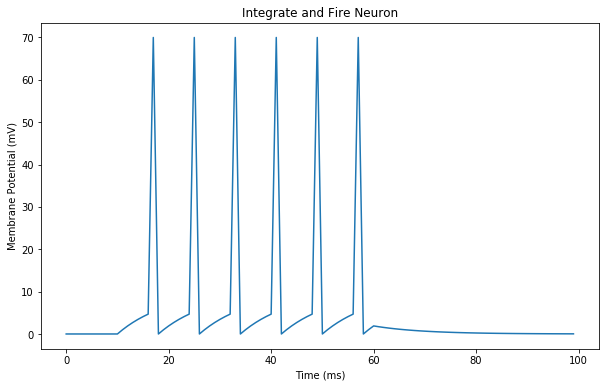

In [3]:
"""
    Run model
"""
def run_model(model, title, iterations=100, show_input=False, create_legend=False):
    # run model for iterations
    for _ in range(iterations):
        model.step()
    
    # set time
    time_step = model.cg.time_step
    time = [i*time_step for i in range(iterations)]
    
    # plot stuff
    plt.figure(figsize=(10,6))
    if show_input:
        # Setup axes
        ax1 = plt.axes()
        ax1.set_xlabel('Time (ms)')
        ax1.set_ylabel('Membrane Potential (mV)')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Current (nA)', color='m')
        ax2.tick_params('y', colors='m')
        
        # Loop through each key and plot
        for key in model.plot_store:
            ax1.plot(time, model.plot_store[key], label=key)
        
        # Plot current
        ax2.plot(time, model.cg.I_vals, 'm--', label='Input')  
        
        # create legend if set
        if create_legend:
            ax1.legend()
    else:
        # Loop through each key and plot
        for key in model.plot_store:
            plt.plot(time, model.plot_store[key], label=key)
        # Label Axes
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
    
        # create legend if set
        if create_legend:
            plt.legend()
    
    # set title and show plots
    plt.title(title)
    plt.show()
    
# create integrate and fire model with defaults and run model
run_model(integrate_and_fire(), 'Integrate and Fire Neuron')

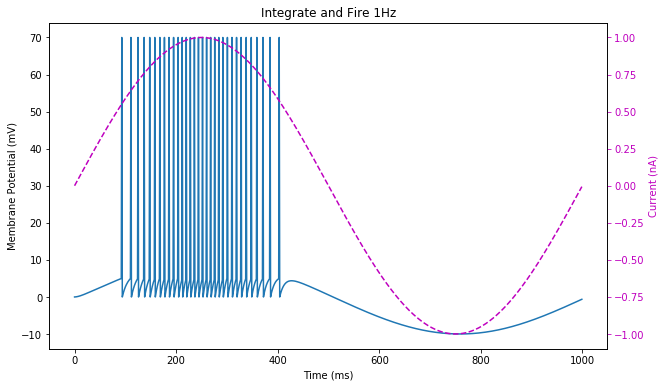

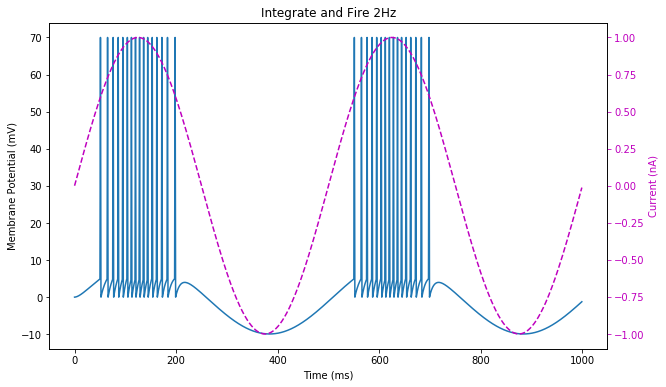

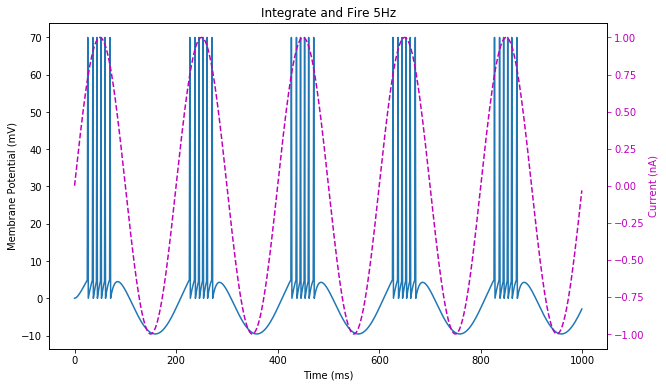

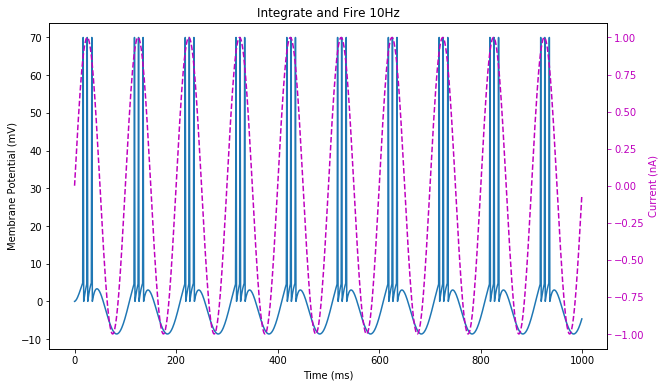

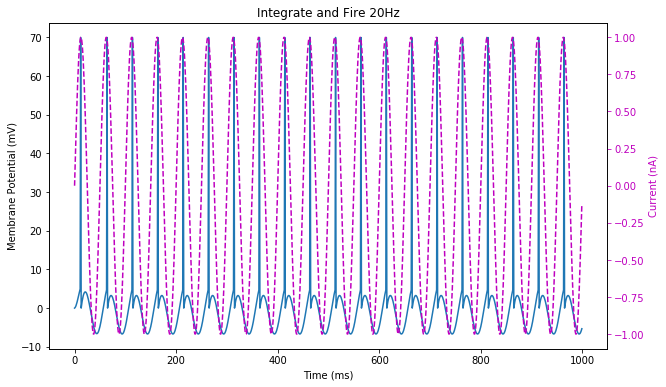

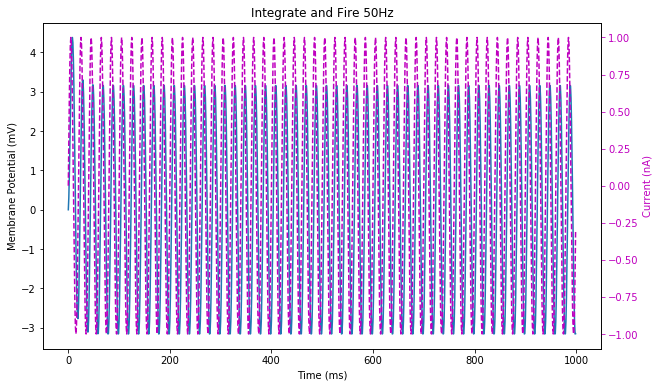

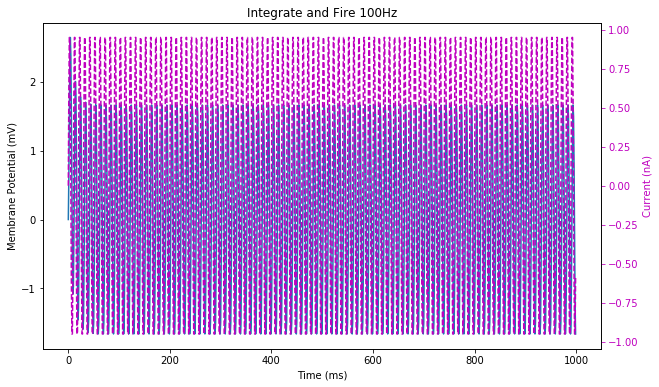

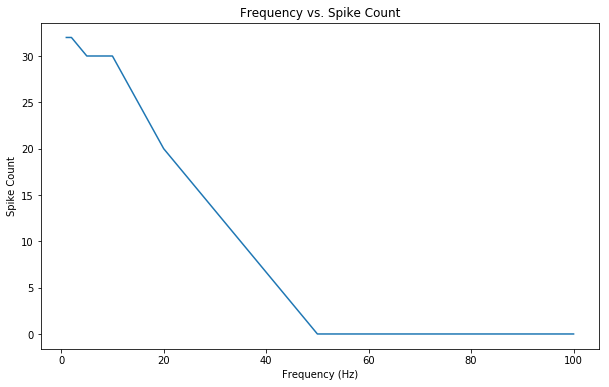

In [4]:
"""
    Run various sinusoidal currents on integrate and fire model
""" 
def run_sinusoidal_models(model, title, I=1, create_legend=False):
    # set frequncies to run
    frequency = [1, 2, 5, 10, 20, 50, 100]
    
    # create model with sinusoidal currents for each frequency and run
    sinusoid_model = []
    for f in frequency:
        sinusoid_model.append(model(cg=current_generator(I=I, It_start=0, It=1000, freq=f)))
        run_model(
            sinusoid_model[-1],'{} {}Hz'.format(title,f),
            iterations=1000,
            show_input=True,
            create_legend=create_legend
        )

    # plot spike count vs. frequency    
    spike_counts = [m.spike_count for m in sinusoid_model]
    plt.figure(figsize=(10,6))
    plt.plot(frequency, spike_counts)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Spike Count')
    plt.title('Frequency vs. Spike Count')
    plt.show()

# run integrate and fire model
run_sinusoidal_models(integrate_and_fire, 'Integrate and Fire')

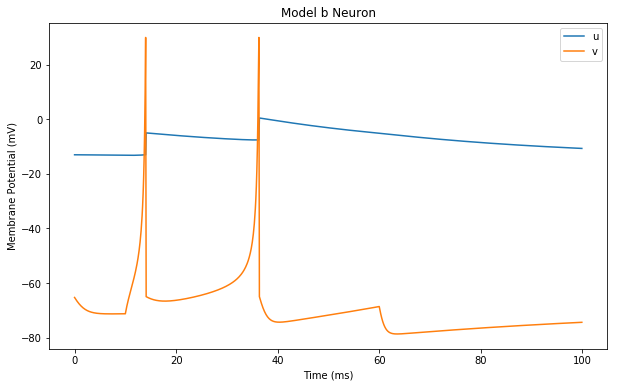

In [5]:
"""
    Model part b
"""

class model_b:
    """
        A class representing the model described in part b
    """
    def __init__(self, cg=current_generator(), a=0.02, b=0.2, c=-65, d=8, v =-65):
        """
            Defined Constants/Initial values:
            a = 0.02
            b = 0.2
            c = -65
            d = 8
            v = -65
            u = b*v
        """
        
        # Assign values to object parameters
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.v = v
        self.u = b*v
        
        # Store current generator
        self.cg = cg
        
        # Create dict to store plot data
        self.plot_store = {}
        self.plot_store['u'] = []
        self.plot_store['v'] = []
        
        # set reset flag so we can reset voltage
        self.reset = False
        
        # keep track of spike counts
        self.spike_count = 0
        
    def new_params(self, u, v, I):
        """
            Calculates new parameters using Euler's method
            
        """
        # Calculate derivatives
        v_prime = 0.1*(0.04*v**2 + 5*v + 140 - u + I)
        u_prime = 0.1*(self.a*(self.b*v - u))
        
        # Calculate new v and u
        v_new = v + v_prime
        u_new = u + u_prime
        
        return u_new, v_new 
    
    def set_params(self, u, v):
        """
            Sets appropriate voltage compared to threshold
        """
        # check if voltage is >equal to 30
        if v >= 30:
            self.reset = True # clamp to set values on next iteration
            self.spike_count += 1 # add to spike count
            return self.u, 30
        else:
            return u, v
    
    def step(self):
        """
            Runs one step of the model
        """
        # get the current from the generator
        I = self.cg()
        
        # set params to set values if flag set
        if self.reset:
            self.u = self.u + self.d
            self.v = self.c
            
            # "reset" reset flag
            self.reset = False
        else:
            # calculate and set new voltage
            self.u, self.v = self.set_params(*self.new_params(self.u, self.v, I))
            
        # append voltage to list
        self.plot_store['u'].append(self.u)
        self.plot_store['v'].append(self.v)
        
# create model b with I = 10 nA for 50 ms and run model
run_model(
    model_b(cg=current_generator(I=10, It=500, It_start=100, time_step=0.1)),
    'Model b Neuron', iterations=1000, create_legend=True)

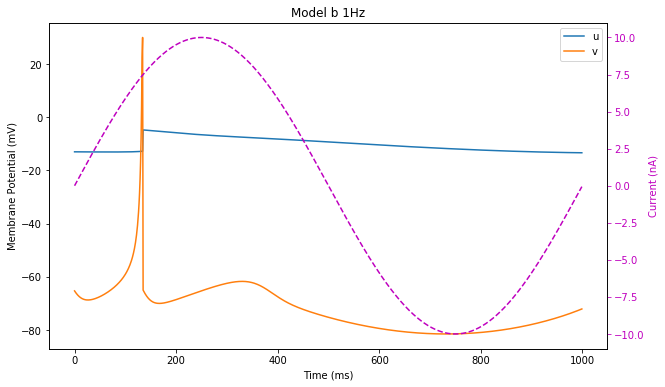

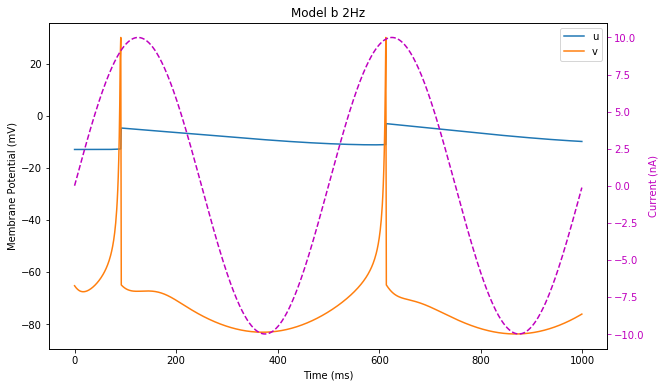

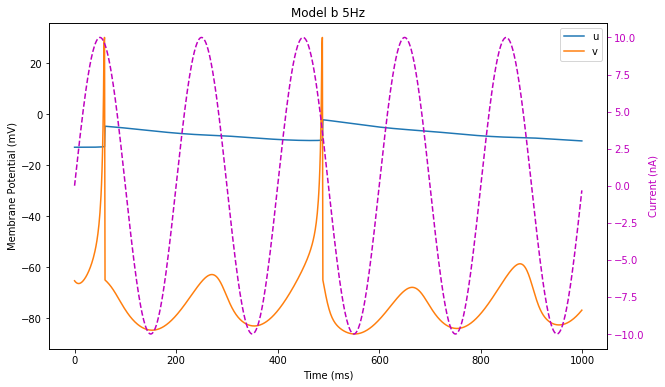

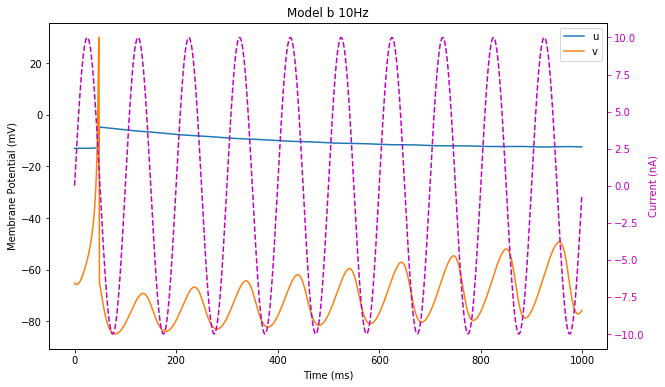

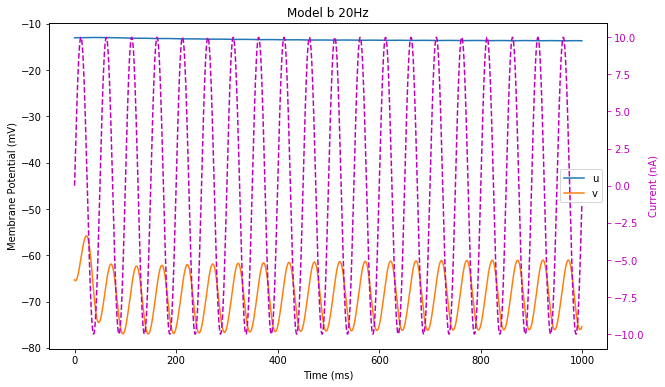

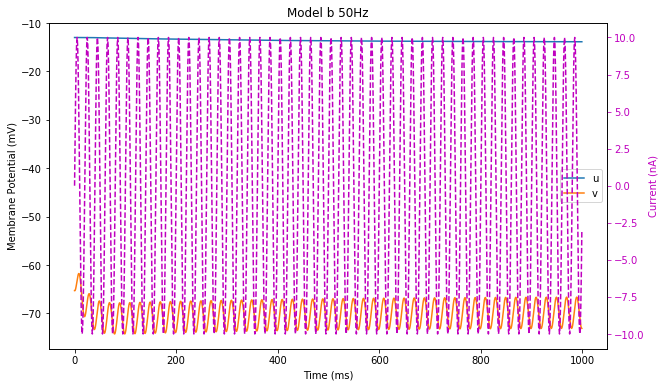

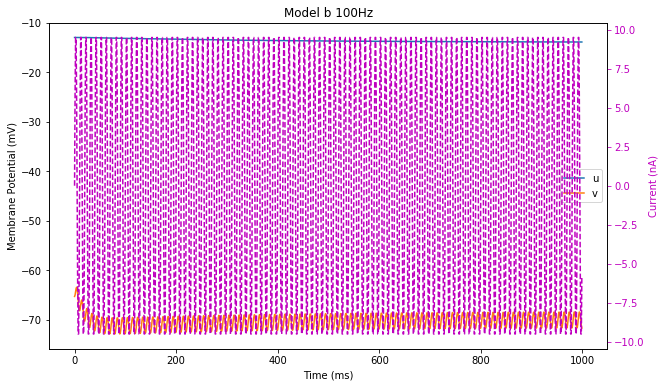

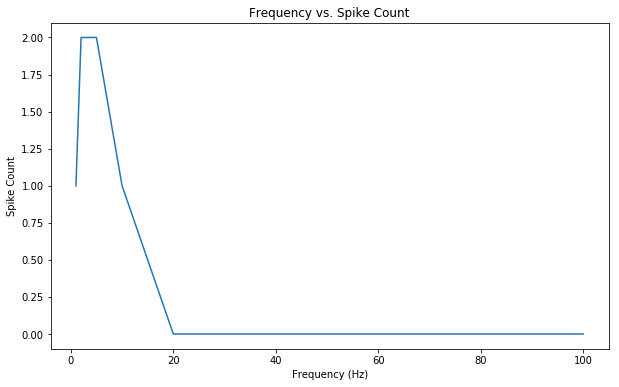

In [6]:
"""
    Run different frequencies
"""
# Run for different sinusoidal inputs
run_sinusoidal_models(model_b, 'Model b', I=10, create_legend=True)